# 🔹 Model Building for Diabetic Retinopathy (DR) Classification
## We Will be Building a Deep Learning Based Feature Extraction and Classification pipeline for Diabetic Retinopathy (DR) stage classification

# ✅ Approach Overview
## 1️⃣ Feature Extraction using Deep Learning Models
    - GoogleNet🏆: Captures multi-scale features using Inception modules.
    - ResNet-16🔄: Uses residual connections to avoid vanishing gradients.
    - Custom CNN Model : Implemented Custom CNN Model

## 2️⃣ Classification using SVM
## Once the deep learning models extract high-level features, we will use Support Vector Machine (SVM) for classification
    - SVM works well on extracted feature vectors instead of raw images.
    - It helps in better generalizations and robust classification of DR stages.

# 🔹 Why Not Use CNN for Classification Instead of SVM?
    - Deep Learning requires more labeled data, whereas SVM works well with limited samples.
    - SVM is computationally efficient compared to training a deep CNN from scratch.
    - Using deep features + SVM is a hybrid approach that balances deep learning and classical ML.

# (1st Aproach) Using Pre-Trained Models for Feature Extraction

## The Extracted feature vector represents patterns like blood vessel abnormalities, exudates, and hemorrhages in Retinal Images.

In [28]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_incep
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
# Force Tensorflow to use only the RTX 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        if 'RTX 2050' in details.get('device_name', ''):
            try:
                tf.config.experimental.set_virtual_device_configuration(
                    gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
                )
                print("Using GPU:", details)
            except ValueError as e:
                print(f"Warning: {e}\nMemory growth cannot be set due to virtual device configuration.")
            break  # Use the first available RTX 2050 GPU
else:
    print("No compatible GPU found. Using CPU instead.")

Using GPU: {'device_name': 'NVIDIA GeForce RTX 2050', 'compute_capability': (8, 6)}


In [17]:
# Enabling mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

In [18]:
# defining the image size and batch size
img_size = (224,224)
batch_size = 32

In [19]:
# PreProcessed Dataset
data_dir = r'C:\Users\bhagi\Desktop\AI_ML_Projects\Early_Detection_of_Diabetic_Retinopathy\preprocessed'

In [20]:
# Defining output directory for features
output_dir = 'Extracted_features'
os.makedirs(output_dir, exist_ok=True)

# 1) GoogleNet(InceptionV3) + SVM
# 1️⃣ Pretrained GoogleNet (InceptionV3)
    ✅ Pretrained on: ImageNet (Millions of Images)
    ✅ Feature Extraction Power: Strong for object recognition
    ✅ How it Works:

        Uses Inception modules → Extracts multi-scale features (small & large details).
        Captures complex patterns like textures, edges, and colors.
        We remove the last classification layer and use only the feature extractor part.

In [21]:
def extract_features_using_inceptionV3():
    print("Starting feature extraction using InceptionV3...")
    start_time = time.time()

    # Loading the pre-trained model
    model = InceptionV3(weights='imagenet',include_top = False, pooling = 'avg')

    # Ensure data directory exists
    if not os.path.exists(data_dir):
        print(f"Error: Dataset directory '{data_dir}' not found.")
        return None, None

    try:
        datagen = ImageDataGenerator(preprocessing_function=preprocess_incep)
        generator = datagen.flow_from_directory(
            data_dir,
            target_size = img_size,
            batch_size = batch_size,
            class_mode = 'sparse',
            shuffle = False
        )
    
        features = model.predict(generator, verbose=1)
        labels = generator.classes
    
        feature_filename = os.path.join(output_dir, 'features_InceptionV3.npy')
        label_filename = os.path.join(output_dir, 'labels_InceptionV3.npy')
    
        np.save(feature_filename, features)
        np.save(label_filename, labels)
    
        print(f'Feature extraction complete for inceptionV3. Time Taken:{time.time()-start_time:.2f}seconds')
        print(f'Saved features to {feature_filename} and labels to {label_filename}')
    
        return features, labels
    except Exception as e:
        print(f'Error during feature Extraction: {e}')
        return None, None

# Extracting Features

In [22]:
features,labels = extract_features_using_inceptionV3()

Starting feature extraction using InceptionV3...
Found 92501 images belonging to 5 classes.
2891/2891 [==============================] - 537s 180ms/step
Feature extraction complete for inceptionV3. Time Taken:560.36seconds
Saved features to Extracted_features\features_InceptionV3.npy and labels to Extracted_features\labels_InceptionV3.npy


In [99]:
import joblib
from sklearn.decomposition import PCA
from openTSNE import TSNE
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV

In [8]:
# Loadding the Extracted Features and Labels
feature_filename = r"C:\Users\bhagi\Desktop\AI_ML_Projects\Early_Detection_of_Diabetic_Retinopathy\notebooks\Extracted_features\features_InceptionV3.npy"
label_filename = r"C:\Users\bhagi\Desktop\AI_ML_Projects\Early_Detection_of_Diabetic_Retinopathy\notebooks\Extracted_features\labels_InceptionV3.npy"

In [9]:
features = np.load(feature_filename)
labels = np.load(label_filename)

In [10]:
features

array([[0.3657  , 0.09875 , 0.152   , ..., 0.3171  , 1.334   , 1.008   ],
       [0.01877 , 0.07477 , 0.04037 , ..., 1.157   , 1.441   , 0.401   ],
       [0.6387  , 0.0998  , 0.1462  , ..., 0.00678 , 0.1976  , 0.0595  ],
       ...,
       [0.1613  , 0.03354 , 0.002497, ..., 0.696   , 1.272   , 1.395   ],
       [0.335   , 0.03528 , 0.288   , ..., 0.7     , 1.537   , 0.3552  ],
       [0.665   , 0.      , 0.1111  , ..., 1.202   , 1.121   , 1.034   ]],
      dtype=float16)

In [11]:
labels

array([0, 0, 0, ..., 4, 4, 4])

In [33]:
# Checking Class Distribution
unique, counts = np.unique(labels, return_counts=True)
print('Class Distribution:',dict(zip(unique,counts)))

Class Distribution: {0: 68953, 1: 4634, 2: 15151, 3: 1259, 4: 2504}


In [15]:
# Printing Feature Shapes
print('Feature Shape:',features.shape)
print('labels Shape:',labels.shape)

Feature Shape: (92501, 2048)
labels Shape: (92501,)


In [12]:
# Standardizing the Features 
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Splitting the feature and labels into training(70%),testing(15%) and validation(15%) sets 

In [72]:
X_train, X_temp, y_train, y_temp = train_test_split(features_scaled, labels, test_size=0.3, random_state=42, stratify = labels)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size = 0.5, random_state=42, stratify= y_temp)

In [83]:
# Reducing the dimensionality using PCA 
pca = PCA(n_components=750)
start_time = time.time()
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)
end_time = time.time()
print(f"PCA Execution Time: {end_time - start_time:.2f} seconds")
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Total variance retained: {explained_variance:.2f}")

PCA Execution Time: 42.77 seconds
Total variance retained: 0.95


In [102]:
# Saving the Preprocessing Objects
joblib.dump(scaler,r'C:\Users\bhagi\Desktop\AI_ML_Projects\Early_Detection_of_Diabetic_Retinopathy\models\scaler.pkl')

['C:\\Users\\bhagi\\Desktop\\AI_ML_Projects\\Early_Detection_of_Diabetic_Retinopathy\\models\\scaler.pkl']

In [101]:
joblib.dump(pca,r'C:\Users\bhagi\Desktop\AI_ML_Projects\Early_Detection_of_Diabetic_Retinopathy\models\pca.pkl')

['C:\\Users\\bhagi\\Desktop\\AI_ML_Projects\\Early_Detection_of_Diabetic_Retinopathy\\models\\pca.pkl']

# Training SVM Classifier

In [84]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

# 1) Implementation of SVM that uses Stochastic Gradient Descent (SGD) for optimization.

In [96]:
sgd_svm = SGDClassifier(loss='hinge',max_iter=3000, tol=1e-3, random_state=42,n_jobs=-1, class_weight='balanced', verbose=3)
start_time = time.time()
sgd_svm.fit(X_train_pca, y_train)
end_time = time.time()
print(f'SGD SVM Training Execution Time: {end_time - start_time:.2f}seconds')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1248.52, NNZs: 750, Bias: -4930.301178, T: 64750, Avg. loss: 451.729301
Total training time: 0.11 seconds.
-- Epoch 2
Norm: 790.46, NNZs: 750, Bias: -4233.673620, T: 64750, Avg. loss: 299.557918
Total training time: 0.11 seconds.
-- Epoch 2
Norm: 565.43, NNZs: 750, Bias: -1645.558274, T: 64750, Avg. loss: 270.565165
Total training time: 0.11 seconds.
-- Epoch 2
Norm: 223.26, NNZs: 750, Bias: -403.092014, T: 64750, Avg. loss: 227.677722
Total training time: 0.11 seconds.
-- Epoch 2
Norm: 90.77, NNZs: 750, Bias: -11.090532, T: 64750, Avg. loss: 158.948605
Total training time: 0.13 seconds.
-- Epoch 2
Norm: 1048.63, NNZs: 750, Bias: -4553.862869, T: 129500, Avg. loss: 93.213889
Total training time: 0.21 seconds.
-- Epoch 3
Norm: 694.61, NNZs: 750, Bias: -4024.984247, T: 129500, Avg. loss: 68.419706
Total training time: 0.21 seconds.
-- Epoch 3
Norm: 396.66, NNZs: 750, Bias: -915.544030, T: 129500, Avg. loss: 64.061258
Total trai

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.4s remaining:   14.1s


Norm: 4.07, NNZs: 750, Bias: -6.180122, T: 5503750, Avg. loss: 0.844351
Total training time: 9.61 seconds.
-- Epoch 86
Norm: 2.02, NNZs: 750, Bias: -0.107544, T: 4597250, Avg. loss: 1.274842
Total training time: 9.67 seconds.
-- Epoch 72
Norm: 2.27, NNZs: 750, Bias: -3.437041, T: 5244750, Avg. loss: 0.905715
Total training time: 9.72 seconds.
-- Epoch 82
Norm: 4.07, NNZs: 750, Bias: -6.205884, T: 5568500, Avg. loss: 0.833193
Total training time: 9.72 seconds.
-- Epoch 87
Norm: 1.93, NNZs: 750, Bias: -0.130622, T: 4662000, Avg. loss: 1.262281
Total training time: 9.81 seconds.
-- Epoch 73
Norm: 3.97, NNZs: 750, Bias: -6.244700, T: 5633250, Avg. loss: 0.851345
Total training time: 9.83 seconds.
-- Epoch 88
Norm: 2.25, NNZs: 750, Bias: -3.317813, T: 5309500, Avg. loss: 0.892053
Total training time: 9.84 seconds.
-- Epoch 83
Norm: 1.95, NNZs: 750, Bias: -0.123203, T: 4726750, Avg. loss: 1.254566
Total training time: 9.94 seconds.
-- Epoch 74
Norm: 3.98, NNZs: 750, Bias: -6.060939, T: 56980

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.6s finished


# Evaluating SGD SVM on validation set

In [91]:
y_val_pred_sgd = sgd_svm.predict(X_val_pca)
val_accuracy_sgd = accuracy_score(y_val, y_val_pred_sgd)
print('Validation Accuracy (SGD SVM ):', val_accuracy_sgd)
print('Validation Classification Report (SGD SVM): \n', classification_report(y_val, y_val_pred_sgd))

Validation Accuracy (SGD SVM ): 0.6326030556356299
Validation Classification Report (SGD SVM): 
               precision    recall  f1-score   support

           0       0.83      0.76      0.80     10344
           1       0.09      0.17      0.12       695
           2       0.27      0.22      0.24      2273
           3       0.13      0.37      0.19       189
           4       0.27      0.47      0.34       375

    accuracy                           0.63     13876
   macro avg       0.32      0.40      0.34     13876
weighted avg       0.68      0.63      0.65     13876



# Evaluating SGD SVM on test set

In [92]:
y_test_pred_sgd = sgd_svm.predict(X_test_pca)
test_accuracy_sgd = accuracy_score(y_test, y_test_pred_sgd)
print("Test Accuracy (SGD SVM):", test_accuracy_sgd)
print("Test Classification Report (SGD SVM):\n", classification_report(y_test, y_test_pred_sgd))

Test Accuracy (SGD SVM): 0.6327927927927928
Test Classification Report (SGD SVM):
               precision    recall  f1-score   support

           0       0.83      0.77      0.80     10343
           1       0.11      0.20      0.14       695
           2       0.27      0.22      0.24      2272
           3       0.12      0.34      0.18       189
           4       0.23      0.41      0.30       376

    accuracy                           0.63     13875
   macro avg       0.31      0.39      0.33     13875
weighted avg       0.68      0.63      0.65     13875



# Plotting the ROC-AUC Curve for SGD SVM

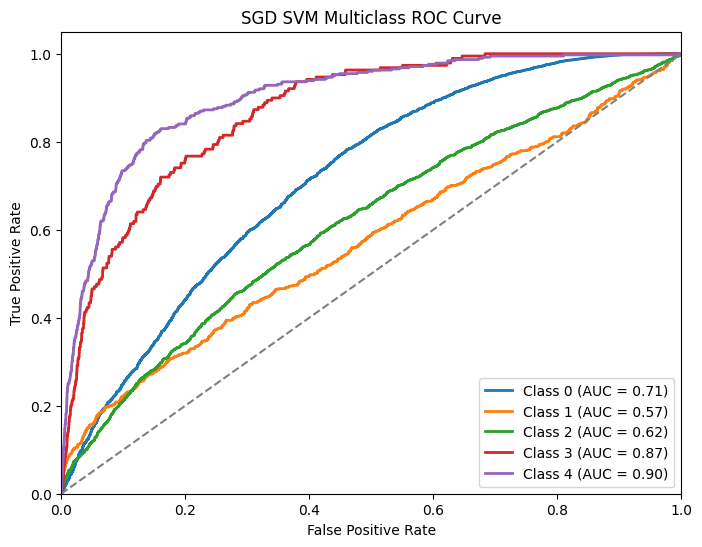

In [94]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
y_test_score_sgd = sgd_svm.decision_function(X_test_pca)

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_score_sgd[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SGD SVM Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [103]:
# Saving the SGD SVM model
joblib.dump(sgd_svm,r'C:\Users\bhagi\Desktop\AI_ML_Projects\Early_Detection_of_Diabetic_Retinopathy\models\sgd_svm.pkl')

['C:\\Users\\bhagi\\Desktop\\AI_ML_Projects\\Early_Detection_of_Diabetic_Retinopathy\\models\\sgd_svm.pkl']

# 2) Implementation of SVM by finding the optimal hyperparameters

# Hyperparameter Tuning for Optimized SVM 

In [85]:
param_grid = {'alpha': [0.0001, 0.001, 0.01], 'loss':['hinge'], 'penalty': ['l2','l1'], 'max_iter':[1000,2000]}
svm_grid = GridSearchCV(SGDClassifier(random_state=42, n_jobs=-1, class_weight= 'balanced'), param_grid, cv=3, n_jobs=-1, verbose=3)
start_time  = time.time()
svm_grid.fit(X_train_pca, y_train)
end_time = time.time()
print(f'SVM Hyperparamter Tuning Execution Time: {end_time - start_time:.2f} seconds')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Hyperparamter Tuning Execution Time: 1966.44 seconds


# Training Optimized SVM Classifier 

In [86]:
svm_model = svm_grid.best_estimator_
start_time = time.time()
svm_model.fit(X_train_pca, y_train)
end_time = time.time()
print(f'SVM Training Execution Time: {end_time - start_time:.2f}seconds')

SVM Training Execution Time: 14.27seconds


# Evaluating on Validation Set

In [87]:
y_val_pred = svm_model.predict(X_val_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
print('Validation Accuracy:', val_accuracy)
print('Test Classification Report:\n', classification_report(y_val, y_val_pred))

Validation Accuracy: 0.726722398385702
Test Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86     10344
           1       0.21      0.09      0.13       695
           2       0.37      0.19      0.25      2273
           3       0.15      0.35      0.21       189
           4       0.27      0.46      0.34       375

    accuracy                           0.73     13876
   macro avg       0.36      0.40      0.36     13876
weighted avg       0.70      0.73      0.70     13876



# Evaluating on Testing Set

In [88]:
y_test_pred = svm_model.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test Accuracy:',test_accuracy)
print('Test Classification Report:\n', classification_report(y_test,y_test_pred))

Test Accuracy: 0.728936936936937
Test Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87     10343
           1       0.21      0.09      0.13       695
           2       0.39      0.20      0.26      2272
           3       0.14      0.31      0.19       189
           4       0.24      0.41      0.30       376

    accuracy                           0.73     13875
   macro avg       0.36      0.38      0.35     13875
weighted avg       0.70      0.73      0.71     13875



# Plotting the ROC-AUC Curve for optimized SVM

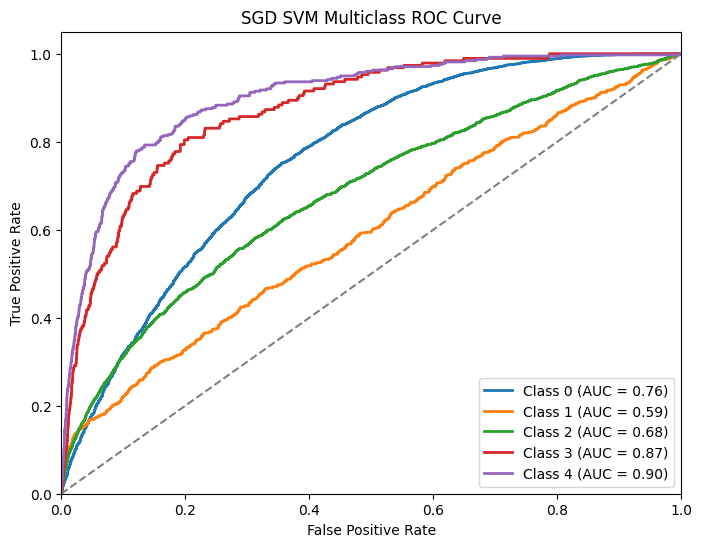

In [95]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
y_test_score_sgd = svm_model.decision_function(X_test_pca)

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_score_sgd[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SGD SVM Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [104]:
# Saving the SVM model
joblib.dump(svm_model, r'C:\Users\bhagi\Desktop\AI_ML_Projects\Early_Detection_of_Diabetic_Retinopathy\models\svm_model.pkl')

['C:\\Users\\bhagi\\Desktop\\AI_ML_Projects\\Early_Detection_of_Diabetic_Retinopathy\\models\\svm_model.pkl']

# Visualizing PCA-reduced features with labels

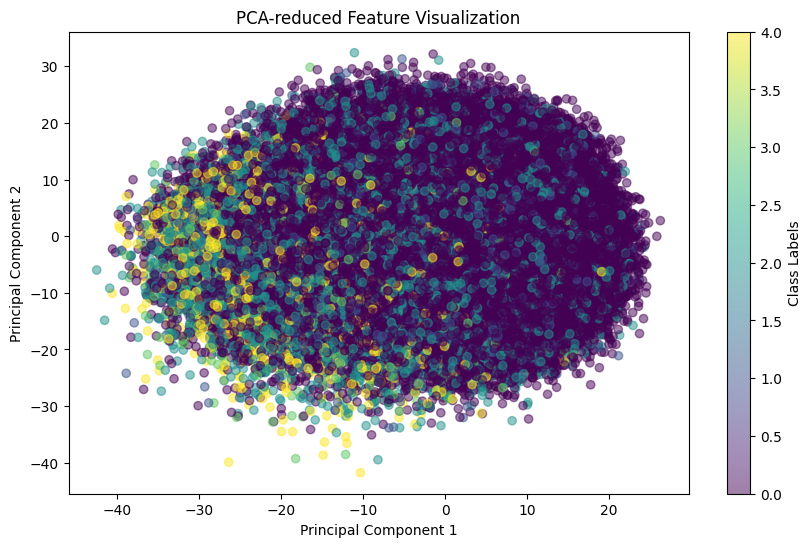

In [82]:
plt.figure(figsize=(10,6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.colorbar(label='Class Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA-reduced Feature Visualization')
plt.show()